In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [25]:
from collections import defaultdict
import os
from os.path import isdir, join
from itertools import chain

In [3]:
from scipy.spatial import distance
from matplotlib import pyplot as plt
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm_notebook
import matplotlib_pretty_tex as pgf

In [23]:
import utils
out_dir = 'output/ut_residual/'
if not isdir(out_dir):
    os.makedirs(out_dir)

In [5]:
%time clusters, = utils.load(names=['clusters'])
scenarios = clusters.scenario.cat.categories.values

CPU times: user 2min 17s, sys: 46.3 s, total: 3min 4s
Wall time: 5min 1s


In [6]:
def get_distances_for_run(run_number):
    dists_abs = defaultdict(list)
    dists_xy = defaultdict(list)
    fuc_r = fake_ut_clusters.query(f'run_number == {run_number}')
    # for event_number in tqdm_notebook(fake_ut_clusters.event_number.unique()):
    for event_number in fake_ut_clusters.event_number.unique():
        fuc_e = fuc_r.query(f'event_number == {event_number}')

        # Get the points for this event in the true geometry
        data_o = fuc_e.query(f'scenario == "Original_DB"')[['x', 'y']].values
        if len(data_o) == 0:
            continue

        for scenario in scenarios:
            if scenario == 'Original_DB':
                continue
            # Get the points for this event in this scenario
            data_p = fuc_e.query(f'scenario == "{scenario}"')[['x', 'y']].values
            # Find the distance between all combinations of points
            dist = distance.cdist(data_p, data_o)
            dists_abs[scenario].append(np.min(dist, axis=1))  # dist)
            # Find the distance in x and y
            dist_xy = data_p - data_o[dist.argmin(axis=1)]
            dists_xy[scenario].append(dist_xy)
    return dists_abs, dists_xy

In [7]:
fake_ut_clusters = clusters.query('channel_id < 0').copy()
assert len(fake_ut_clusters.z.unique()) == 1
fake_ut_clusters.eval('track_number = -channel_id - run_number*10**10 - event_number*10**3', inplace=True)

## Method

In [8]:
data = fake_ut_clusters.query('(run_number == 5224339) & (event_number == 46173)')
data_o = data.query('scenario == "Original_DB"')
data_p = data.query('scenario == "tip_x=0um_y=+1000um_sigma=0.5"')

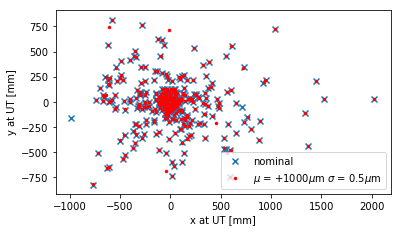

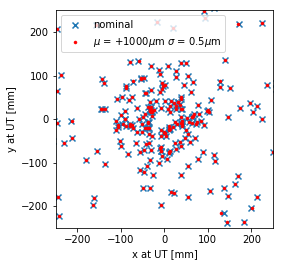

In [31]:
plt.scatter(data_o.x, data_o.y, marker='x', label='nominal')
plt.scatter(data_p.x, data_p.y, marker='.', lw=0.5, c='r', label=utils.format_label('tip_x=0um_y=+1000um_sigma=0.5'))
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='best')
plt.xlabel('x at UT [mm]')
plt.ylabel('y at UT [mm]')
pgf.savefig(join(out_dir, 'ut_cross-section.pgf.png'))

plt.figure()
plt.scatter(data_o.x, data_o.y, marker='x', label='nominal')
plt.scatter(data_p.x, data_p.y, marker='.', lw=0.5, c='r', label=utils.format_label('tip_x=0um_y=+1000um_sigma=0.5'))
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='best')
plt.xlabel('x at UT [mm]')
plt.xlim((-250, 250))
plt.ylabel('y at UT [mm]')
plt.ylim((-250, 250))
pgf.savefig(join(out_dir, 'ut_cross-section_zoomed.pgf.png'))

## Residuals

In [10]:
if False:
    # Just do a single run
    result = [get_distances_for_run(rn) for rn in fake_ut_clusters.run_number.unique()[:1]]
else:
    # Do all runs in parallel
    result = Parallel(n_jobs=64)(
        delayed(get_distances_for_run)(rn)
        for rn in fake_ut_clusters.run_number.unique()
    )

In [13]:
dist_abs = {s: np.concatenate(np.concatenate([result[i][0][s] for i in range(len(result))]))
            for s, v in result[0][0].items()}
dist_xy = {s: np.concatenate(np.concatenate([result[i][1][s] for i in range(len(result))]))
           for s, v in result[0][1].items()}

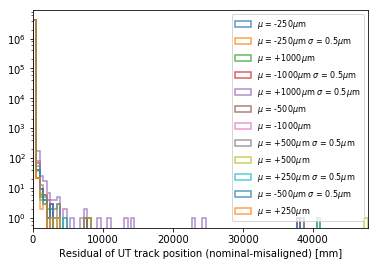

In [28]:
x_lim = max([max(d) for d in dist_abs.values()])
for scenario, dist in dist_abs.items():
    plt.hist(dist, bins=np.linspace(0, x_lim, 100), label=utils.format_label(scenario), histtype='step', lw=1.5, alpha=0.75)
plt.legend(loc='best', fontsize=8)
plt.xlim((0, x_lim))
plt.yscale('log')
plt.xlabel('Residual of UT track position (nominal-misaligned) [mm]')
pgf.savefig(join(out_dir, 'normal_vs_misaligned_full.pgf.png'))

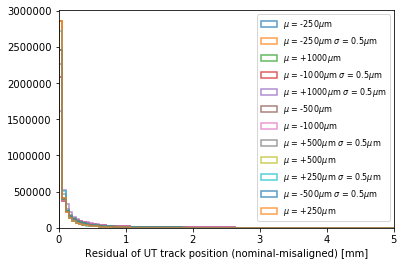

In [44]:
for scenario, dist in dist_abs.items():
    plt.hist(dist, bins=np.linspace(0, 5, 100), label=utils.format_label(scenario), histtype='step', lw=1.5, alpha=0.75)
plt.legend(loc='best', fontsize=8)
plt.xlim((0, 5))
plt.xlabel('Residual of UT track position (nominal-misaligned) [mm]')
pgf.savefig(join(out_dir, 'normal_vs_misaligned_part_zoom.pgf.png'))

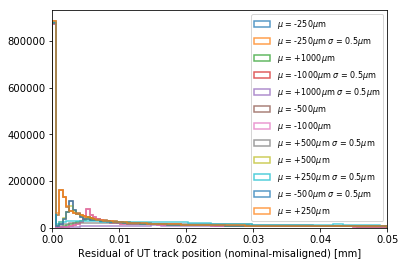

In [41]:
for scenario, dist in dist_abs.items():
    plt.hist(dist, bins=np.linspace(0, 0.05, 100), label=utils.format_label(scenario), histtype='step', lw=1.5, alpha=0.75)
plt.legend(loc='best', fontsize=8)
plt.xlim((0, 0.05))
plt.xlabel('Residual of UT track position (nominal-misaligned) [mm]')
pgf.savefig(join(out_dir, 'normal_vs_misaligned_full_zoom.pgf.png'))

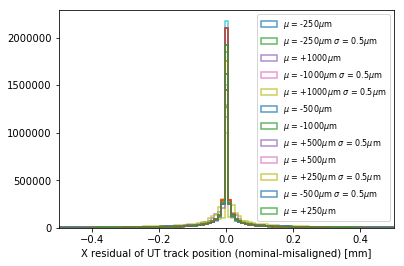

In [42]:
for scenario, dist in dist_xy.items():
    plt.hist(dist, bins=np.linspace(-0.5, 0.5, 100), label=utils.format_label(scenario), histtype='step', lw=1.5, alpha=0.75)
plt.legend(loc='best', fontsize=8)
plt.xlim((-0.5, 0.5))
plt.xlabel('X residual of UT track position (nominal-misaligned) [mm]')
pgf.savefig(join(out_dir, 'x_residual.pgf.png'))

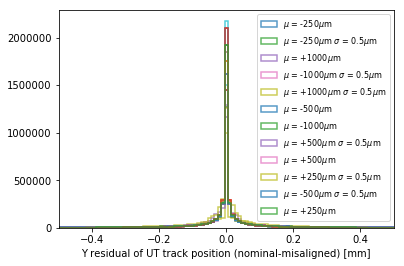

In [43]:
for scenario, dist in dist_xy.items():
    plt.hist(dist, bins=np.linspace(-0.5, 0.5, 100), label=utils.format_label(scenario), histtype='step', lw=1.5, alpha=0.75)
plt.legend(loc='best', fontsize=8)
plt.xlim((-0.5, 0.5))
plt.xlabel('Y residual of UT track position (nominal-misaligned) [mm]')
pgf.savefig(join(out_dir, 'y_residual.pgf.png'))